In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as K
from sklearn import preprocessing

# Sell prices.csv

The sell_prices.csv file contains the weekly (averaged) prices for each of the 3049 products in the dataset.
Note that the amount of weeks for each product is not the same, as some products might have not been available at the start date, or became unavailable later on(?).

Not yet combined with the training data



In [2]:
PRICE_DTYPES = {"store_id": "category", 
                "item_id": "category", 
                "wm_yr_wk": "int16", 
                "sell_price":"float32" }

prices = pd.read_csv("m5-forecasting-accuracy/sell_prices.csv", dtype = PRICE_DTYPES)

print(prices.shape)
prices.head(5)

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Calendar.csv

Have not combined calendar.csv yet with the training set

In [3]:
CAL_DTYPES={"weekday": "category", 
            'wm_yr_wk': 'int16', 
            "wday": "int16",
            "month": "int16", 
            "year": "int16", 
            "event_name_1": "category", 
            "event_name_2": "category", 
            "event_type_1": "category", 
            "event_type_2": "category", 
            "snap_CA": "float32", 
            'snap_TX': 'float32', 
            'snap_WI': 'float32'}

calendar = pd.read_csv("m5-forecasting-accuracy/calendar.csv", dtype = CAL_DTYPES)

calendar["date"] = pd.to_datetime(calendar["date"]) # this changes the format of the 'date' column to handier one

for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            calendar[col] = calendar[col].cat.codes.astype("int16") # changes category to int16! so now Boolean
            calendar[col] -= calendar[col].min() # this changes the -1 values in the event_name and _type columns to 0

print(calendar.shape)
calendar.head(5)

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0.0,0.0,0.0
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0.0,0.0,0.0
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0.0,0.0,0.0
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1.0,1.0,0.0
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1.0,0.0,1.0


# Sales_train_validation.csv

Next up: the training set

6 columns with information about the 30490 products, then 1913 columns denoting the number of sales on each of the 1913 days.
For a total of 1919 columns.

In [4]:
FIRST_DAY = 350
is_train = True

In [5]:
tr_last = 1913 # ???
max_lags = 57 # ???
start_day = max(1 if is_train  else tr_last-max_lags, FIRST_DAY)
numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]

dtype = {numcol:"float32" for numcol in numcols} 

train = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv", dtype = dtype)

#print(train.head(5))

# Gaussian process

In [6]:
def GaussianProcess(product_sales, n, h):
    model_start = len(product_sales) - (n + h)
    model_end = len(product_sales) - h
    
    X = [[x] for x in range(model_start, model_end)]

    # observations
    Y = list(product_sales[model_start:model_end])

    # https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

    # the range we wish to predict for (includes existing points)
    x = [[x] for x in range(model_start, len(product_sales))]

    kernel = K.RBF() + K.ExpSineSquared() * K.RationalQuadratic() 

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, Y)

    Y_pred = gp.predict(x, return_std=False)
    
    return x, Y_pred, model_start

# RMSSE

In [7]:
import math

def RMSSE(h, n, Y, Y_pred):
    """
    h: forecasting horizon (28)
    n: number of datapoints the model was trained on (280)
    Y: ground truth values (length 280 + 28)
    Y_pred: predicted values (length 280 + 28)"""
    
    numerator = 0
    denominator = 0
    
    for t in range ((n), (n+h)):              # from 280 to 307 (the 'future' timepoints)
        numerator += (Y[t] - Y_pred[t])**2
    for t in range(1, (n)):                   # from 1 to 279   (the existing timepoints)
        denominator += (Y[t] - Y[t-1])**2
        
    denominator = (1/(n-1)) * denominator
    
    return math.sqrt((1/h)*(numerator/denominator))

# Computing weight of a series

In [8]:
def compute_weight(item_id, store_id, sales):
    p = prices.loc[(prices['item_id'] == item_id) & (prices['store_id'] == store_id)]
    last_4_weeks_prices = list(p.tail(4)['sell_price'])
    
    sales_week1 = sum(sales[1885:1892])
    sales_week2 = sum(sales[1892:1899])
    sales_week3 = sum(sales[1899:1906])
    sales_week4 = sum(sales[1906:1913])

    weight = sales_week1 * last_4_weeks_prices[0] + sales_week2 * last_4_weeks_prices[1] + \
        sales_week3 * last_4_weeks_prices[2] + sales_week4 * last_4_weeks_prices[3]
    return weight

In [9]:
def plot(x, sales, model_start, Y_pred):
    plt.figure()

    plt.scatter(x, sales[model_start:], label='Data')
    plt.plot(x, Y_pred, label='Prediction', color='orange')

    plt.xlabel('$day$')
    plt.ylabel('$sales$')

    plt.xlim(1611, 1913)
    plt.ylim(0, 6)

    plt.legend(loc='upper left')

    plt.show()

# Weighted RMSSE (WRMSSE)

308
308
0.8267793781015418
226.26000308990479


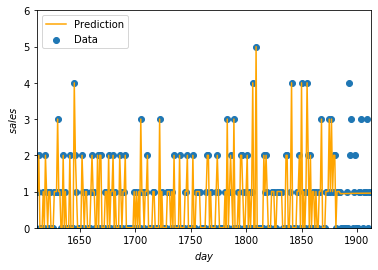

308
308
0.4255872946210542
7.940000057220459


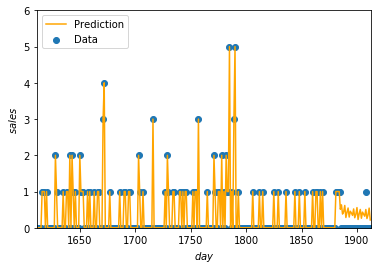

308
308
0.5790668091698488
47.52000045776367


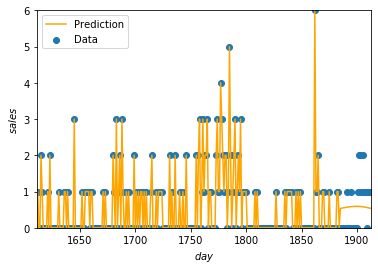

C:\Users\Jaap\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


308
308
0.6638139886512481
236.63999319076538


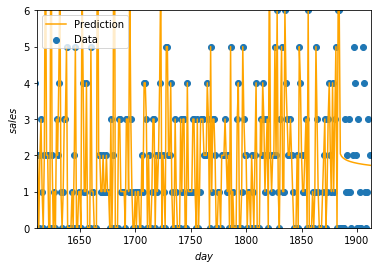

308
308
0.7793858376205636
109.44000434875488


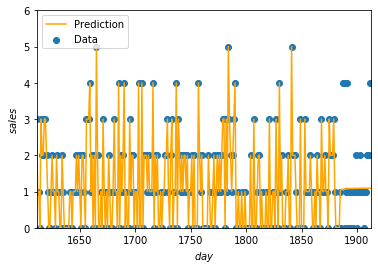

0.7332660866488643

In [22]:
series = []

p1 = train.iloc[0]
p2 = train.iloc[1]
p3 = train.iloc[2]
p4 = train.iloc[3]
p5 = train.iloc[4]

series.extend([p1, p2, p3, p4, p5])

def WRMSSE(series):
    h = 28   # forecasting horizon
    n = 280 # the amount of data points we want to train our model on
    
    errors = []
    weights = []
    
    for prod in series:
        id = prod[1]
        store_id = prod[4]
        sales = list(prod[6:])

        x, Y_pred, model_start = GaussianProcess(sales, n, h)
        
        Y = sales[model_start:]
        error = RMSSE(h, n, Y, Y_pred)
        errors.append(error)
        print(error)
        
        weight = compute_weight(id, store_id, sales)
        weights.append(weight)
        print(weight)
        
        plot(x, sales, model_start, Y_pred)
        
    
    total_weight = sum(weights)
    normalized_weights = [x / total_weight for x in weights]
    
    weighted_errors_normalized = [weight * error for weight,error in zip(normalized_weights, errors)]
    
    normalized_WRMSSE = sum(weighted_errors_normalized)

    return normalized_WRMSSE

        
WRMSSE(series)